In [1]:
from utils import DPEM
from common import *

In [2]:
from sklearn.mixture import BayesianGaussianMixture
from scipy.stats import multivariate_normal
from scipy.special import logsumexp

from sklearn.datasets import make_moons

def get_proj(R, A):
    
    return np.matmul(np.matmul(R, R.T), A.T)

def generate_grid_points(X):
    x = np.linspace(np.max(X)*1.5, np.min(X)*1.5, num=100)
    xx, yy = np.meshgrid(x, x)
    grid = np.c_[xx.ravel(), yy.ravel()]

    return xx, yy, grid

def get_log_likelihood(X, mixture_weights, mixture_mus, mixture_covs):
    """
    모든 데이터포인트의 log likelihood 계산
    inf를 다 대체하는 것이 아니라 log-sum-exp tricks 써서 underflow 없앰. (새로 수정한 부분)
    """
    N, _ = X.shape
    K = len(mixture_weights)  # K is the number of components in the mixture
    log_likelihoods = np.zeros((N, K))

    # Calculate the log-likelihood for each component for each data point
    for k in range(K):
        log_likelihoods[:, k] = np.log(mixture_weights[k]) + multivariate_normal.logpdf(X, mean=mixture_mus[k], cov=mixture_covs[k,:,:], allow_singular=True)
    
    # Use logsumexp to calculate the log-likelihood for the mixture
    log_likelihood = logsumexp(log_likelihoods, axis=1)
    
    # Return the total log-likelihood by summing over all data points
    return log_likelihood

def fit_DPGM(X, covariance_type, alpha=None):
    dpgmm = BayesianGaussianMixture(n_components=30, covariance_type=covariance_type, init_params="k-means++", 
                                    n_init=10, weight_concentration_prior=alpha)
    dpgmm.fit(X)
    mixture_weights = dpgmm.weights_
    mixture_mus = dpgmm.means_
    if dpgmm.covariance_type == 'full':
        mixture_covs = dpgmm.covariances_
    else:
        mixture_covs = np.array([np.eye(X.shape[1]) * dpgmm.covariances_[idx] for idx in range(30)])
    
    return mixture_weights, mixture_mus, mixture_covs

In [3]:
# Define dataset
n_samples = 2000
noise = 0.05
data, label = make_moons(n_samples=n_samples, noise=0.1, random_state=0)

lower = data[label.astype(bool), :]     # lower half
upper = data[~label.astype(bool), :]    # upper half
lower = lower + [0.35, -0.7]
upper = upper + [-0.35, 0.7]
normal = np.concatenate([lower, upper])

outlier_A = np.array([[-0.6, 0.3]])
outlier_B = np.array([[-1.2, -1.0]])
outlier_C = np.array([[2.2, 1.2]])

# Dataset
X = np.concatenate((normal, outlier_A))
X = np.concatenate((X, outlier_B))
X = np.concatenate((X, outlier_C))

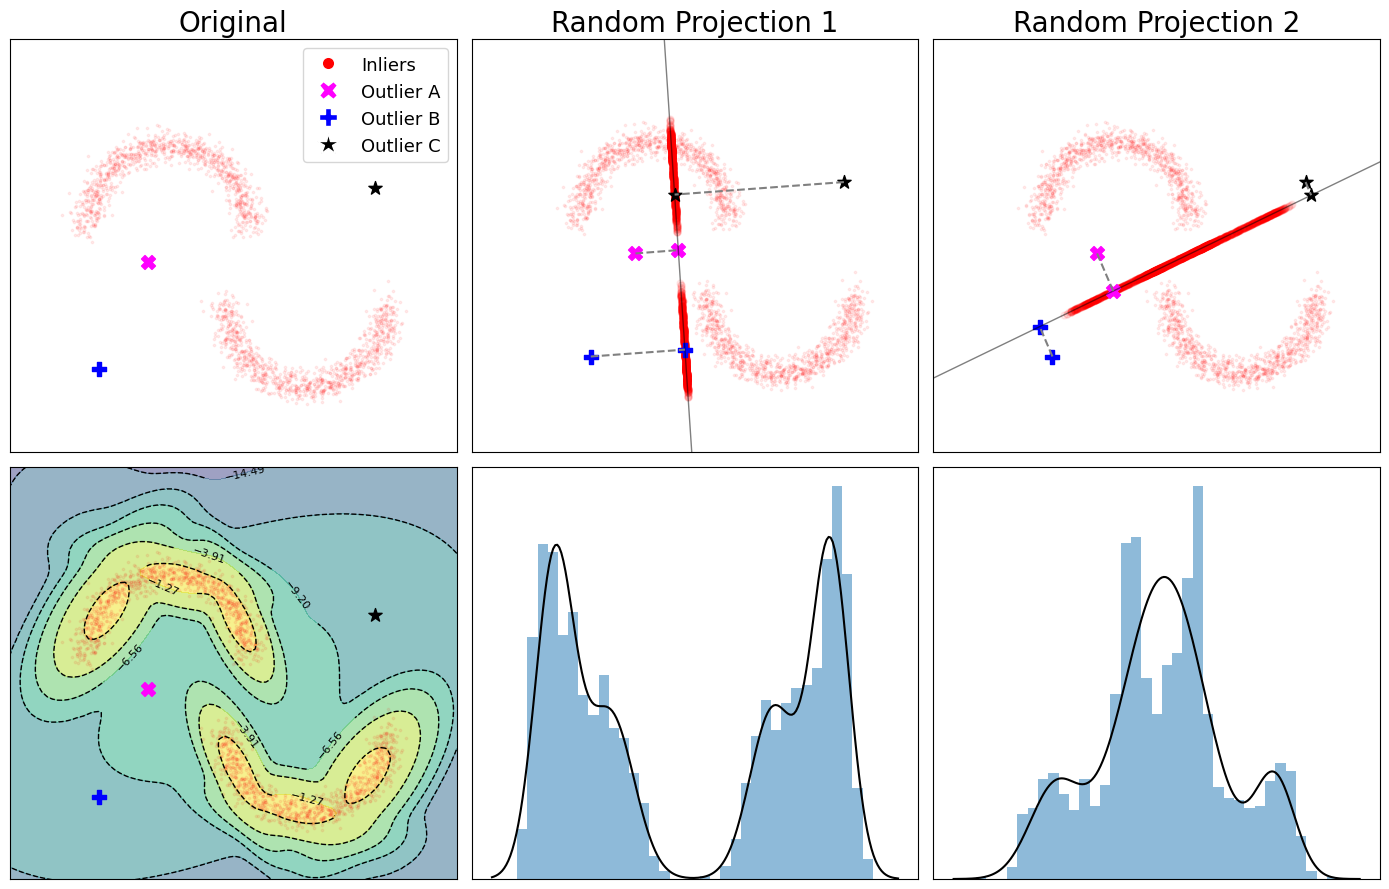

In [4]:
proj_matrices = [np.array([[-0.07080272], [0.99903767]]),
                np.array([[0.91039588], [0.41373824]])]
covariance_type = 'full'

n_row = 2
n_col = 3
plt.figure(figsize=(14, 9))
########################################################
# Original
plt.subplot(n_row, n_col, 1)
plt.scatter(normal[:, 0], normal[:, 1], color="red", s=3, alpha=0.07, label="Inliers")
plt.scatter(outlier_A[:, 0], outlier_A[:, 1], color="magenta", marker="X", s=100, label="Outlier A")
plt.scatter(outlier_B[:, 0], outlier_B[:, 1], color="blue", marker="P", s=100, label="Outlier B")
plt.scatter(outlier_C[:, 0], outlier_C[:, 1], color="black", marker="*", s=100, label="Otulier C")
plt.xticks([])
plt.yticks([])
plt.xlim((-2.3, 3.2))
plt.ylim((-2, 3))
plt.title("Original", fontsize=20)
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Inliers', markerfacecolor='red', markersize=9),
                    Line2D([0], [0], marker='X', color='w', label='Outlier A', markerfacecolor='magenta', markersize=13),
                    Line2D([0], [0], marker='P', color='w', label='Outlier B', markerfacecolor='blue', markersize=13),
                    Line2D([0], [0], marker='*', color='w', label='Outlier C', markerfacecolor='black', markersize=16)]

# Create the figure
plt.legend(handles=legend_elements, prop={'size': 13}, loc='upper right')

########################################################
for i, R in enumerate(proj_matrices):
    R = np.array(R)
    plt.subplot(n_row, n_col, i+2)

    x_grid = np.linspace(-100, 100, 200)
    x_grid_2d = np.c_[x_grid.reshape(len(x_grid), -1), np.zeros(len(x_grid))]
    y_grid = R[0, 0] + x_grid * R[1, 0]

    ## original 
    plt.scatter(normal[:, 0], normal[:, 1], color="red", s=3, alpha=0.07, label="normal")
    plt.scatter(outlier_A[:, 0], outlier_A[:, 1], color="magenta", marker="X", s=100, label="A")
    plt.scatter(outlier_B[:, 0], outlier_B[:, 1], color="blue", marker="P", s=100, label="B")
    plt.scatter(outlier_C[:, 0], outlier_C[:, 1], color="black", marker="*", s=100, label="C")

    ## projection axis
    plt.plot(get_proj(R, x_grid_2d)[0, :], get_proj(R, x_grid_2d)[1, :], color="black", linewidth=1, alpha=0.5, linestyle="-")
    plt.title("Original", fontsize=20)

    ## projected
    normal_proj = get_proj(R, normal)
    outlier_A_proj = get_proj(R, outlier_A)
    outlier_B_proj = get_proj(R, outlier_B)
    outlier_C_proj = get_proj(R, outlier_C)
    plt.scatter(normal_proj[0, :], normal_proj[1, :], s=25, color="red", alpha=0.07)
    plt.scatter(outlier_A_proj[0, :], outlier_A_proj[1, :], color="magenta", marker="X", s=100)
    plt.scatter(outlier_B_proj[0, :], outlier_B_proj[1, :], color="blue", marker="P", s=100)
    plt.scatter(outlier_C_proj[0, :], outlier_C_proj[1, :], color="black", marker="*", s=100)

    plt.plot([outlier_A[0,0], outlier_A_proj[0,0]], [outlier_A[0,1], outlier_A_proj[1,0]], linestyle="--", color="grey")
    plt.plot([outlier_B[0,0], outlier_B_proj[0,0]], [outlier_B[0,1], outlier_B_proj[1,0]], linestyle="--", color="grey")
    plt.plot([outlier_C[0,0], outlier_C_proj[0,0]], [outlier_C[0,1], outlier_C_proj[1,0]], linestyle="--", color="grey")
    plt.xlim((-2.8, 3.2))
    plt.ylim((-2.2, 3))
    plt.xticks([])
    plt.yticks([])
    plt.title("Random Projection {}".format(i+1), fontsize=20)

########################################################
## 1. Original Data
mixture_weights, mixture_mus, mixture_covs = fit_DPGM(X, covariance_type)

# Generate grid points
xx, yy, X_grid = generate_grid_points(X)
X_grid_loglik = get_log_likelihood(X_grid, mixture_weights, mixture_mus, mixture_covs)  # Loglikelihood for grid points

# Contour plot
plt.subplot(n_row, n_col, 4)
l = np.linspace(X_grid_loglik.min(), X_grid_loglik.max(), 25)  # 더 세밀한 coutour line
l = np.append(l[-1:], l[::-1][1::3])  # 봉우리 잡히게

contourf = plt.contourf(xx, yy, X_grid_loglik.reshape(xx.shape), cmap='viridis', alpha=0.5, levels=l[::-1])  # Filled Contour
contours = plt.contour(xx, yy, X_grid_loglik.reshape(xx.shape), linewidths=1, colors='k', levels=l[::-1])    # Contour line
plt.clabel(contours, inline=True, fontsize=8)  # text for contour level

# Scatter plot for data points
plt.scatter(normal[:, 0], normal[:, 1], color="red", s=3, alpha=0.07, label="Inliers")
plt.scatter(outlier_A[:, 0], outlier_A[:, 1], color="magenta", marker="X", s=100, label="Outlier A")
plt.scatter(outlier_B[:, 0], outlier_B[:, 1], color="blue", marker="P", s=100, label="Outlier B")
plt.scatter(outlier_C[:, 0], outlier_C[:, 1], color="black", marker="*", s=100, label="Otulier C")
plt.xlim((-2.3, 3.2))
plt.ylim((-2, 3))
plt.xticks([])
plt.yticks([])

########################################################
for i, R in enumerate(proj_matrices):
    X_proj = np.matmul(X, R)

    mixture_weights, mixture_mus, mixture_covs = fit_DPGM(X_proj, covariance_type)
    # Generate grid points
    X_grid = np.linspace(min(X_proj)-0.25, max(X_proj)+0.25, 200).reshape(-1, 1)
    loglikelihood = get_log_likelihood(X_grid, mixture_weights, mixture_mus, mixture_covs)
    likelihood = np.exp(loglikelihood)

    plt.subplot(n_row, n_col, 5+i)
    plt.hist(X_proj, density=True, bins=35, alpha=0.5)  # Histogram of projected points
    plt.plot(X_grid, likelihood, color='black')  # Fitted
    plt.xticks([])
    plt.yticks([])
    # plt.ylabel('Density', fontsize=12)

plt.tight_layout()
# plt.savefig('./Figures/RandomProjection.pdf', dpi=200, bbox_inches='tight')
plt.show()

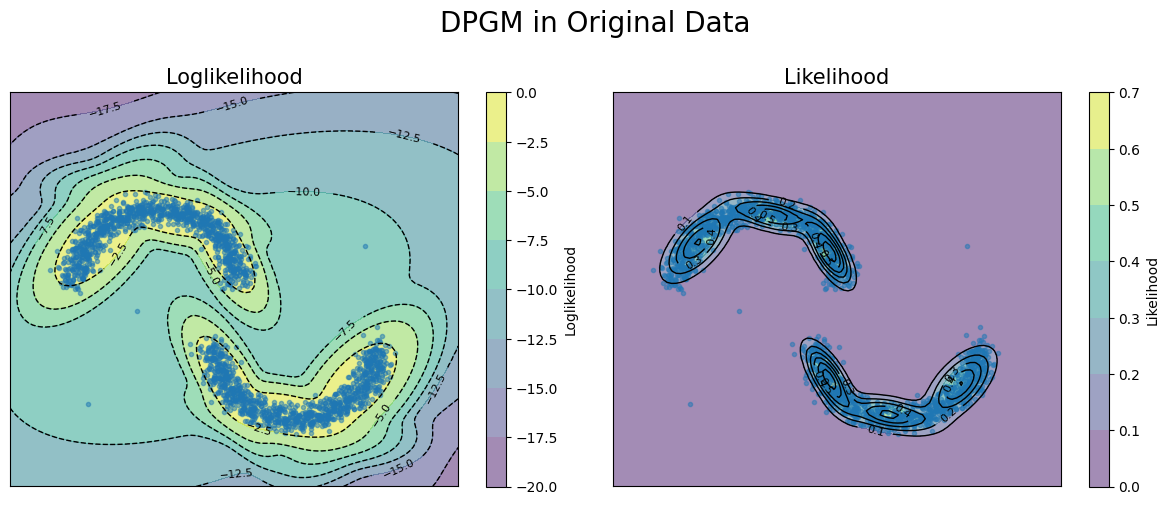

In [ ]:
plt.figure(figsize=(12, 5))
for i in range(2):
    plt.subplot(1, 2, i+1)
    target = X_grid_loglik if i == 0 else np.exp(X_grid_loglik)
    text = 'Loglikelihood' if  i == 0 else 'Likelihood'

    # Filled Contour plot
    contourf = plt.contourf(xx, yy, target.reshape(xx.shape), cmap='viridis', alpha=0.5)
    plt.colorbar(contourf, label=text)  # colorbar for filled contour
    # Draw line of contour
    contours = plt.contour(xx, yy, target.reshape(xx.shape), linewidths=1, colors='k')
    plt.clabel(contours, inline=True, fontsize=8)  # text for contour level

    # Scatter plot for data points
    plt.scatter(X[:, 0], X[:, 1], label='Original Data', marker='.', alpha=0.5)
    # Plot decorations
    plt.title(text, fontsize=15)
    plt.xticks([])
    plt.yticks([])

plt.suptitle(f'DPGM in Original Data', y=1.001, fontsize=20)
plt.tight_layout()
plt.show()


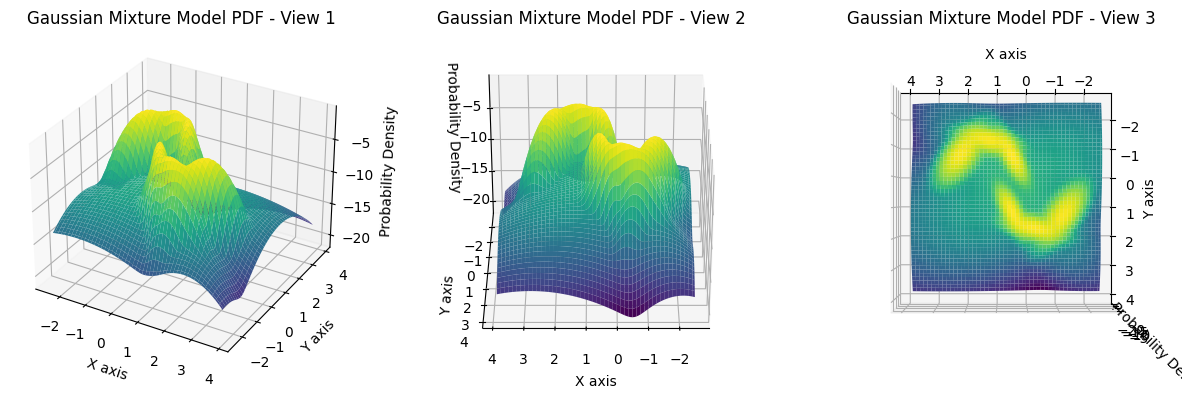

In [5]:
fig = plt.figure(figsize=(15, 6))

# First subplot
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(xx, yy, X_grid_loglik.reshape(xx.shape), cmap='viridis')
ax1.set_xlabel('X axis')
ax1.set_ylabel('Y axis')
ax1.set_zlabel('Probability Density')
ax1.set_title('Gaussian Mixture Model PDF - View 1')

# Second subplot with different view angle
ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(xx, yy, X_grid_loglik.reshape(xx.shape), cmap='viridis')
ax2.view_init(30, 90) # Change view angle
ax2.set_xlabel('X axis')
ax2.set_ylabel('Y axis')
ax2.set_zlabel('Probability Density')
ax2.set_title('Gaussian Mixture Model PDF - View 2')

# Second subplot with different view angle
ax3 = fig.add_subplot(133, projection='3d')
ax3.plot_surface(xx, yy, X_grid_loglik.reshape(xx.shape), cmap='viridis')
ax3.view_init(90, 90) # Change view angle
ax3.set_xlabel('X axis')
ax3.set_ylabel('Y axis')
ax3.set_zlabel('Probability Density')
ax3.set_title('Gaussian Mixture Model PDF - View 3')

plt.show()

In [13]:
import plotly.graph_objects as go

# Create the 3D plot
fig = go.Figure(data=[go.Surface(z=X_grid_loglik.reshape(xx.shape), x=xx, y=yy)])

# Update the layout
fig.update_layout(title='Gaussian Mixture Model PDF', autosize=False,
                  width=700, height=700,
                  margin=dict(l=65, r=50, b=65, t=90))

# Show the plot
fig.show()
